In [1]:
import pandas as pd
from percentage_analysis import plot_distrib, plotly_distrib


*************Graph quotebank*************
mean before #MeToo = 0.165
mean after #MeToo = 0.183
p-value 1.1179704411412053e-23
*************Graph women*************
mean before #MeToo = 0.394
mean after #MeToo = 0.422
p-value 9.082051964880962e-23
*************Graph metoo*************
mean before #MeToo = 0.408
mean after #MeToo = 0.426
p-value 0.00884331886446011


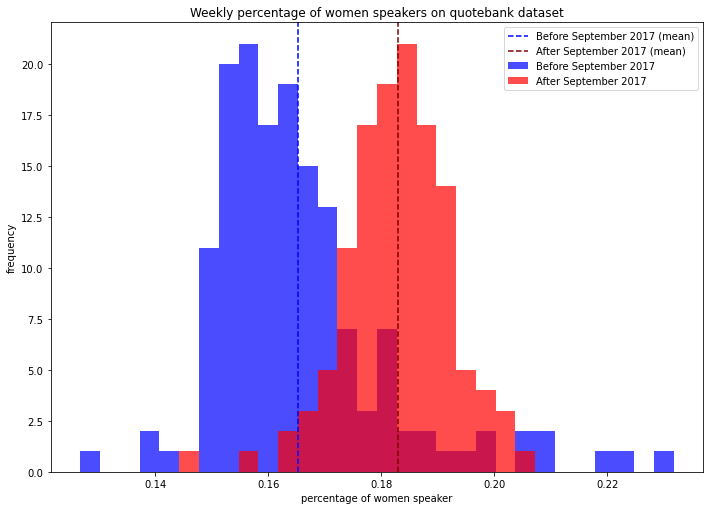

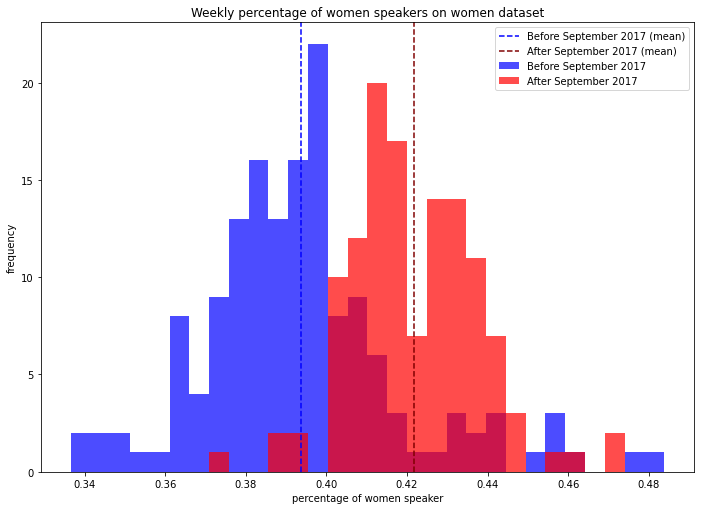

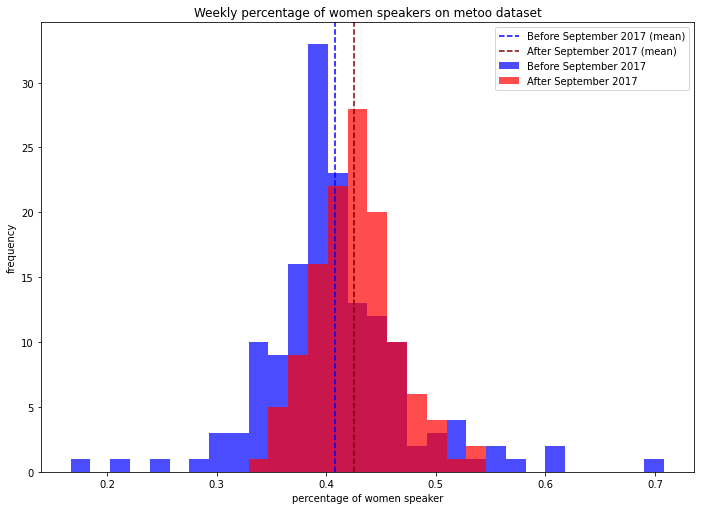

In [3]:
PATH_DATA = './data/data_nlp/weelky_count/'

datasets = ['quotebank','women','metoo']
years = range(2015,2021)
DF = []

for dataset in datasets:
       #reset frames
       frames = []
       for year in years:

              if dataset == 'quotebank':
                     QUOTES_FILE = PATH_DATA + dataset + f'/{year}_count.csv'
                     df_weekly_count = pd.read_csv(QUOTES_FILE, index_col=0)
                     df_weekly_count.drop(df_weekly_count.index[-1], inplace=True)
              else:
                     QUOTES_FILE = PATH_DATA + dataset + f'/quotes-{year}-filtered_weekly_count.json.bz2'
                     df_weekly_count = pd.read_json(QUOTES_FILE, lines=True, compression='bz2', typ='frame')
                     df_weekly_count.drop(df_weekly_count.index[-1], inplace=True)
                     df_weekly_count.drop(df_weekly_count.index[-1], inplace=True)
                     
              #remove useless columns (only keeping male and female count)
              useless_columns = list(df_weekly_count.columns)
              useless_columns.remove('male')
              useless_columns.remove('female')
              df_weekly_count.drop(useless_columns, axis=1, inplace=True)

              #adding the percentage of women column
              df_weekly_count['male_female'] = df_weekly_count.male + df_weekly_count.female
              df_weekly_count['percent_women'] = df_weekly_count.female/df_weekly_count.male_female
              df_weekly_count.dropna(inplace=True)

              frames.append(df_weekly_count)

       #create a df with all the weeks from 2015 to 2020
       df_weekly_all = pd.concat(frames)
       df_weekly_all.reset_index(inplace=True)
       df_weekly_all['date'] = pd.date_range(start='1/1/2015', periods=len(df_weekly_all), freq='W')
       #plot the distributions of weekly women percentage
       plot_distrib(df_weekly_all, dataset)
       DF.append(df_weekly_all)
       
#Uncommenting this function will plot the percentage of women from 2015 to 2020
#plotly_distrib(DF, datasets=datasets)


The p value obtained when performing this t-test is inferior to 0.05. We can therefore reject the null hypothesis for a significance level of 5%. In other words, we can reject the hypothesis according to which the weekly average percentage of women speakers have the same distribution (same mean) either before or after the meetoo movement started. Therefore, we can conclude that the difference between the two scenarios is statistically significant: women were given more voice in the media when talking about subjects linked to MeToo.